In [1]:
import sys
sys.dont_write_bytecode = True
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate
from scipy.optimize import minimize
from qutip import*
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_fluxonium as fluxonium
from Fluxonium_hamiltonians import qchard_coupobj as coupobj
from Fluxonium_hamiltonians import qchard_evolgates as gates
from Fluxonium_hamiltonians import qchard_rotope as op
import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400
plt.close('all')

In [2]:
# Biased noise fluxonium
E_L1 = 0.8
E_C1 = 1
E_J1 = 6.8

E_L2 = 1
E_C2 = 1
E_J2 = 7

J_C = 0.2
phi_ext_A = 0.42*2*np.pi
phi_ext_B = 0.42*2*np.pi

# Gate parameters.
T_gate = 50
transition_to_drive = ('11', '21')
# Pulse shape.
shape = 'gauss'  # 'gauss', 'cos' for 1-cos, or 'square'
sigma = 0.25  # sigma in units of T_gate for shape=='gauss'
drag = False
drag_coeff = 0.2

# Scaling of the ideal value given by the inverse matrix element.
drive_amplitude_factor = 1  # 0.95436
# Drive frequency with respect to the resonance.
delta_omega_d = 0

# Method to calculate the propagator.
# 'propagator - full propagator using qt.propagator
# 'sesolve' - propagator using qt.sesolve for 4 computational states
method = 'propagator'

# Hilbert space.
# nlev_cav = 4
nlev_q = 5

save_figure = False
filename_prefix = 'stuff'

# Indices of the computational space.
comp_space = ['00', '01', '10', '11']
interaction = 'on'

# Transitions to show
states011 = ['11', '21', '22']
states010 = ['10', '20']
states001 = ['01', '02']
states000 = ['00']

# Instantiate objects
qubitA = fluxonium.Fluxonium(
    E_L=E_L1, E_C=E_C1, E_J=E_J1, nlev=nlev_q, phi_ext = phi_ext_A)
qubitB = fluxonium.Fluxonium(
    E_L=E_L2, E_C=E_C2, E_J=E_J2, nlev=nlev_q, phi_ext = phi_ext_B)

system =coupobj.CoupledObjects(
    qubitA, qubitB, [qubitA, qubitB, J_C, 'charge'])

In [3]:
# Calculate the drive frequency.
level1, level2 = transition_to_drive[0], transition_to_drive[1]
omega_d = abs(system.freq(level1, level2)) + delta_omega_d

# Calculate the drive amplitude.
matr_el = np.abs(system.n_ij(qubitA, level1, level2)
                 + system.n_ij(qubitB, level1, level2))
epsilon = drive_amplitude_factor / abs(matr_el)

print('Detuning between 10-20 and 11-21: {:.1f} MHz'.format(
    1000 * np.abs(system.freq('10', '20') - system.freq('11', '21'))))
print('Transition to drive: {} - {} with frequency {:.4f} GHz'.format(
    level1, level2, abs(system.freq(level1, level2))))
print('Drive frequency: {:.4f} GHz'.format(omega_d))
print('Drive amplitude scale factor: {:.4f}'.format(
    drive_amplitude_factor))

Detuning between 10-20 and 11-21: 68.3 MHz
Transition to drive: 11 - 21 with frequency 4.1121 GHz
Drive frequency: 4.1121 GHz
Drive amplitude scale factor: 1.0000


In [4]:
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)

# The time-independent operator part of the drive term.
H_drive = epsilon * (system.n(0) + system.n(1))
H_drive_dummy = 0* (system.n(0) + system.n(1))
if method == 'sesolve':
    # This calculates the evolution operator that works for
    # computational levels only.
    U_t = gates.evolution_compspace_microwave(system.H(), H_drive, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d,interaction=interaction)

elif method == 'propagator':
    # This calculates the evolution operator for the whole system  
    U_t = gates.evolution_operator_microwave(system.H(), H_drive, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)
    U_nothing = gates.evolution_operator_microwave(-system.H(), H_drive_dummy, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)

In [5]:
U_real = gates.change_operator_proj_subspace(
        system, U_t, subspace=comp_space, interaction=interaction)
single_qubit_gates = gates.operator_single_qub_z(system, U_real[-1])
fidelity = gates.fidelity_cz_gate(
    system, U_t, comp_space=comp_space,
    interaction=interaction, single_gates='z')
#Note: this is only for unitary evolution. We shall investigate dephasing errors later.
print('max fidelity during the simulations: ', np.max(fidelity))

print('\n** Final values **')
print('Fidelity: ', fidelity[-1])
print('Diagonal elements of the evolution operator '
      + '(amplitudes and phases with respect to E*t in units of pi)')

max fidelity during the simulations:  0.9920192920116409

** Final values **
Fidelity:  0.9920192920116409
Diagonal elements of the evolution operator (amplitudes and phases with respect to E*t in units of pi)


In [6]:
U_f = U_t[-1]
U_me = {}
for state in comp_space:
    vec = system.eigvec(state, interaction=interaction)
    U_me[state] = U_f.matrix_element(vec.dag(), vec)
for state in comp_space:
    print(state, np.abs(U_me[state]),
          (np.angle(U_me[state]
                    * np.exp(2j * np.pi * system.level(state) * T_gate))) / np.pi)
print('$(\phi_{00} + \phi_{11} - \phi_{01} - \phi_{01})/\pi=$')
print((np.angle(U_me['00']) + np.angle(U_me['11'])
       - np.angle(U_me['01']) - np.angle(U_me['10'])) / np.pi)
phase_accum = (np.angle(U_me['00']) + np.angle(U_me['11'])
               - np.angle(U_me['01']) - np.angle(U_me['10']))
phase_accum = phase_accum / np.pi

initial_state = system.eigvec(transition_to_drive[0])
final_state = system.eigvec(transition_to_drive[1])
P_driven_transition = gates.prob_transition(U_t, initial_state, final_state)

t_2nd_excited = scipy.integrate.trapz(P_driven_transition, t_points)
print('Time spent in the 2nd state for {} - {}: {:.1f} ns'.format(
    transition_to_drive[0], transition_to_drive[1],
    t_2nd_excited))

00 1.000000016381773 0.15310095920972147
01 0.9999781515560712 0.09587519376987466
10 0.9999571701408015 -0.0061394580330057374
11 0.9995704160127278 -0.9912937234944283
$(\phi_{00} + \phi_{11} - \phi_{01} - \phi_{01})/\pi=$
-0.9275511747280182
Time spent in the 2nd state for 11 - 21: 15.1 ns


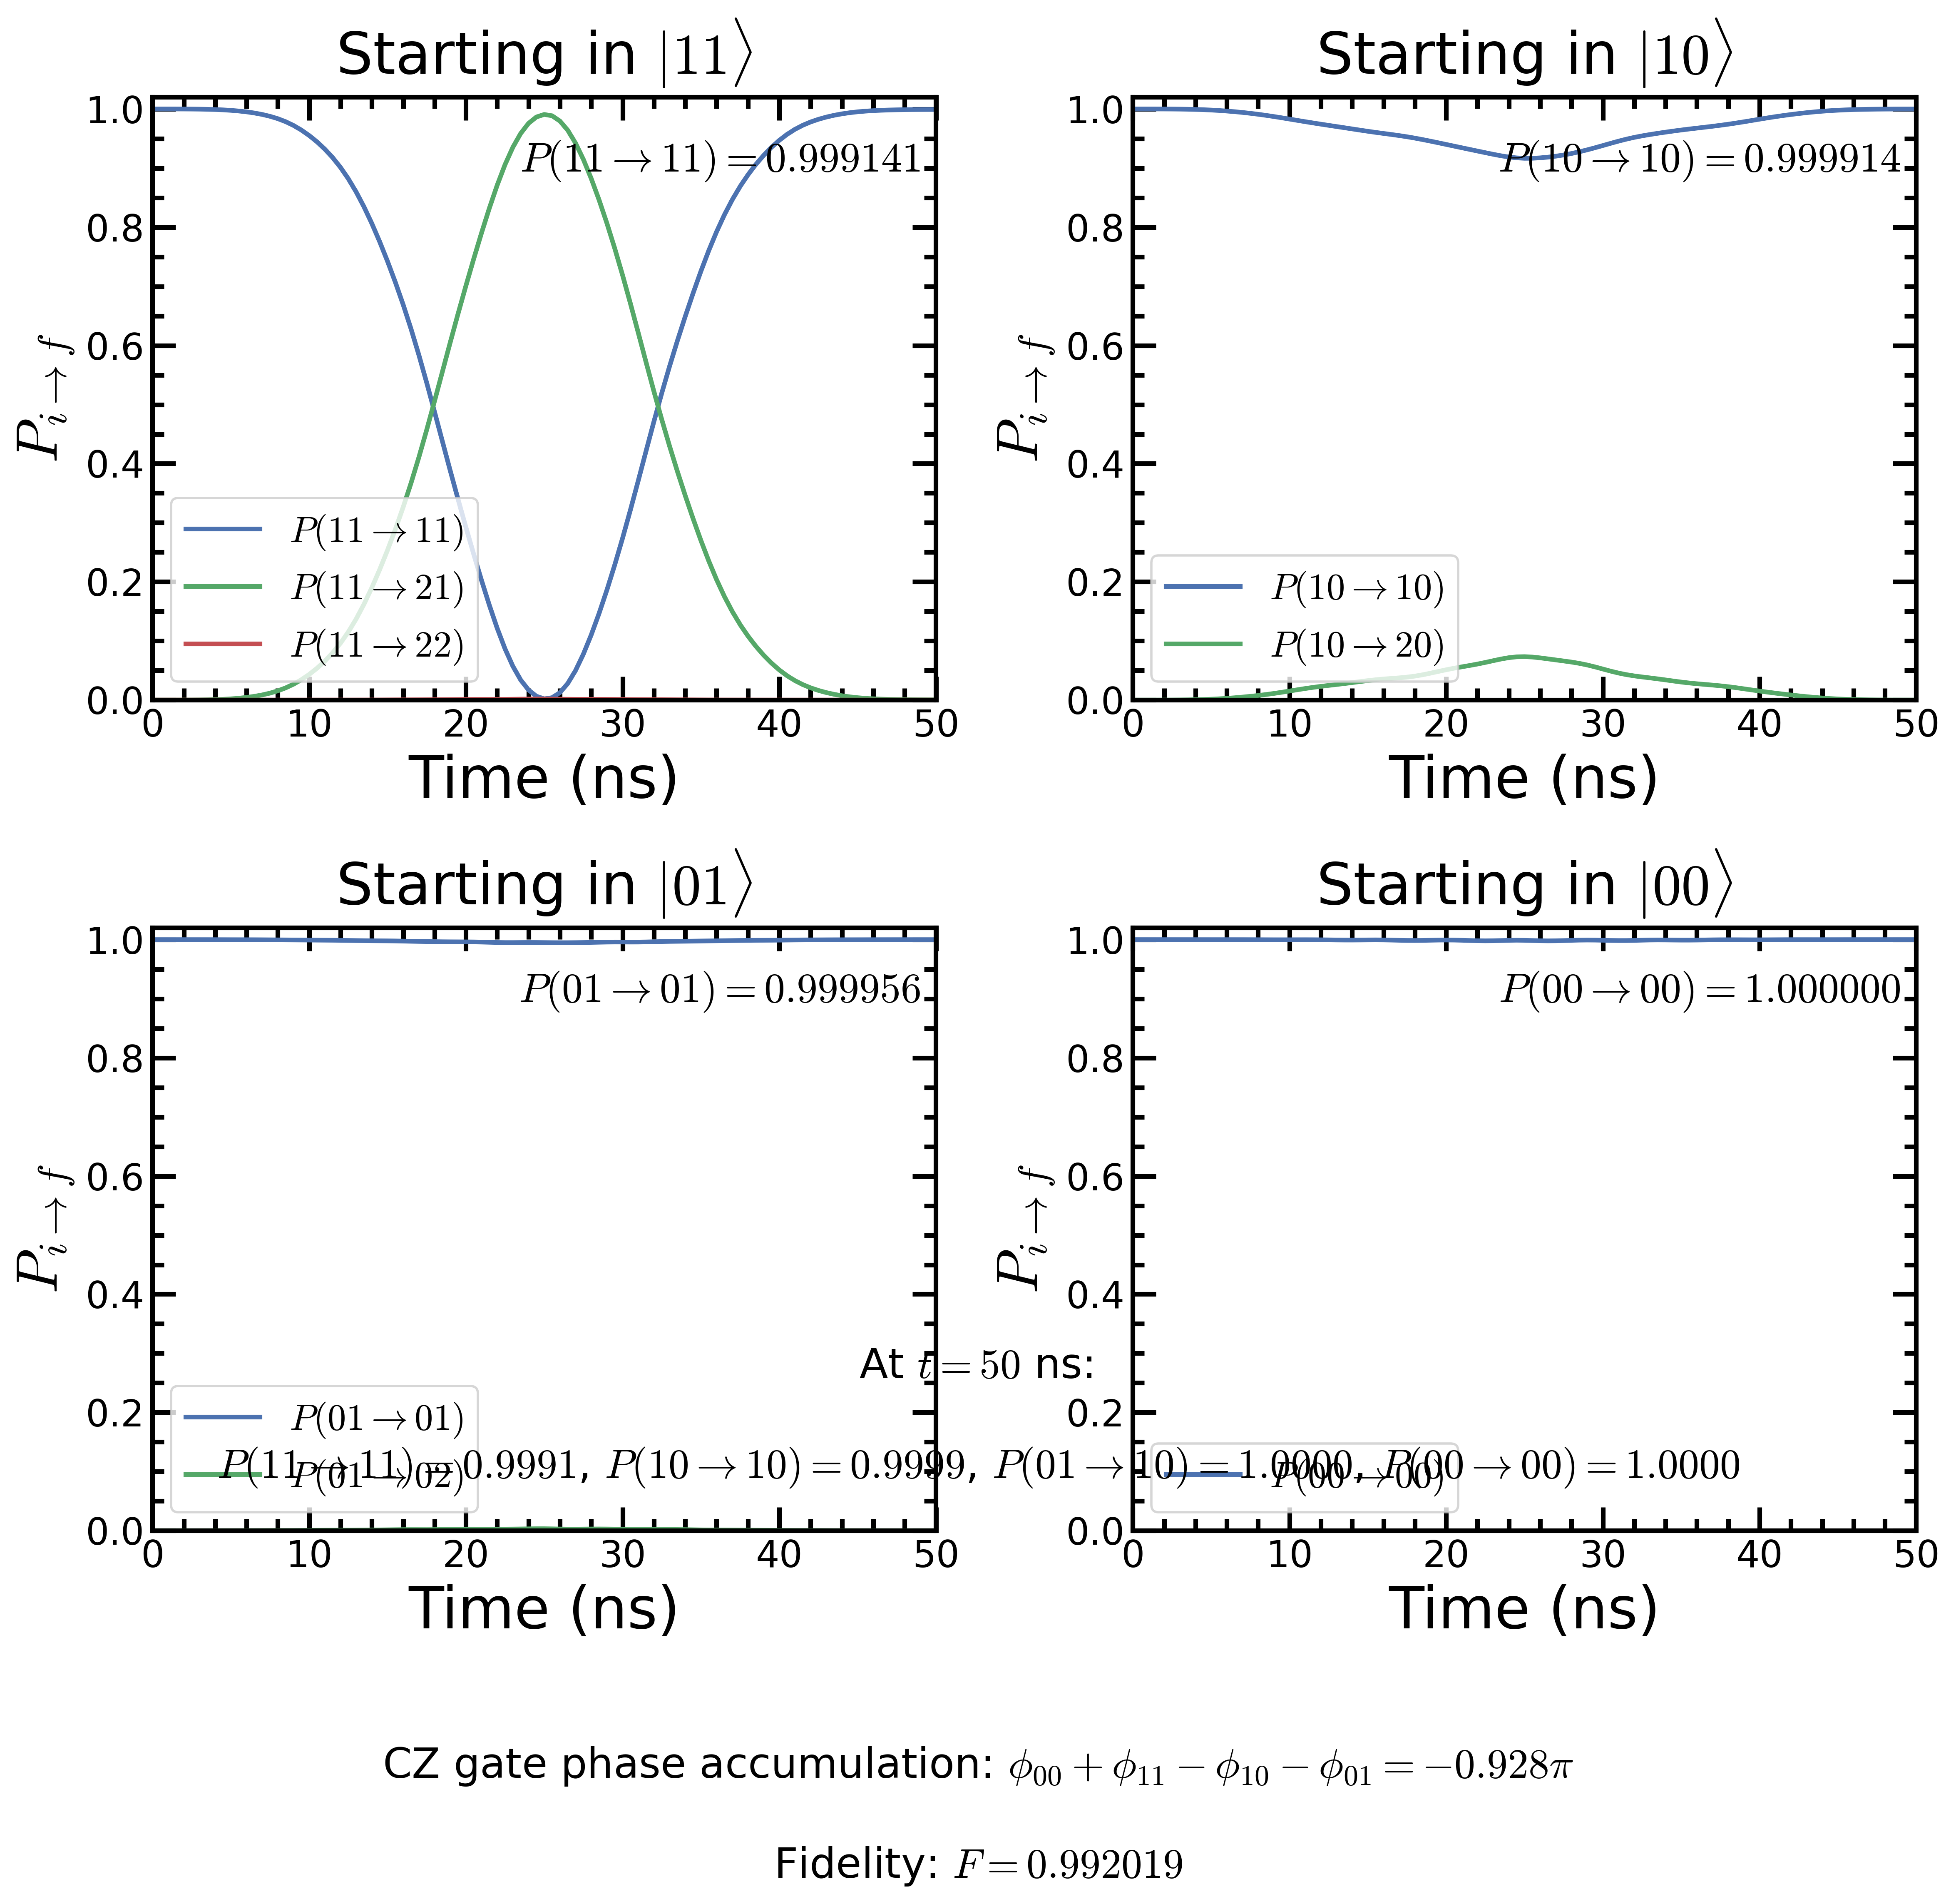

In [7]:
P011 = {}
P010 = {}
P001 = {}
P000 = {}

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

ax011 = axes[0, 0]
ax010 = axes[0, 1]
ax001 = axes[1, 0]
ax000 = axes[1, 1]

for state in states011:
    P011[state] = gates.prob_transition(U_t, system.eigvec('11'), system.eigvec(state))
    ax011.plot(t_points, P011[state], lw=2,
               label=r'$P(11\rightarrow{})$'.format(state))

for state in states010:
    P010[state] = gates.prob_transition(U_t, system.eigvec('10'), system.eigvec(state))
    ax010.plot(t_points, P010[state], lw=2,
               label=r'$P(10\rightarrow {})$'.format(state))

for state in states001:
    P001[state] = gates.prob_transition(U_t, system.eigvec('01'), system.eigvec(state))
    ax001.plot(t_points, P001[state], lw=2,
               label=r'$P(01\rightarrow {})$'.format(state))

for state in states000:
    P000[state] = gates.prob_transition(U_t, system.eigvec('00'), system.eigvec(state))
    ax000.plot(t_points, P000[state], lw=2,
               label=r'$P(00\rightarrow {})$'.format(state))

textfontsize = 18
fig.text(0.5, 0.3, r'At $t = {}$ ns: '.format(int(t_points[-1])),
        fontsize=textfontsize, ha='center')
fig.text(0.5, 0.25,
        r'$P(11\rightarrow 11) = {:.4f}$, '.format(P011['11'][-1])
        + r'$P(10\rightarrow 10) = {:.4f}$, '.format(P010['10'][-1])
        + r'$P(01\rightarrow 10) = {:.4f}$, '.format(P001['01'][-1])
        + r'$P(00\rightarrow 00) = {:.4f}$'.format(P000['00'][-1]),
        fontsize=textfontsize, ha='center')
ax011.text(0.98, 0.93,
           r'$P(11 \rightarrow 11) = {:.6f}$'.format(P011['11'][-1]),
           ha='right', va='top', transform=ax011.transAxes,
           fontsize=textfontsize)
ax010.text(0.98, 0.93,
           r'$P(10 \rightarrow 10) = {:.6f}$'.format(P010['10'][-1]),
           ha='right', va='top', transform=ax010.transAxes,
           fontsize=textfontsize)
ax001.text(0.98, 0.93,
           r'$P(01 \rightarrow 01) = {:.6f}$'.format(P001['01'][-1]),
           ha='right', va='top', transform=ax001.transAxes,
           fontsize=textfontsize)
ax000.text(0.98, 0.93,
           r'$P(00 \rightarrow 00) = {:.6f}$'.format(P000['00'][-1]),
           ha='right', va='top', transform=ax000.transAxes,
           fontsize=textfontsize)
# fig.text(0.65, 0.25, r'$P(10) = {:.4f}$'.format(
#          P010['10'][-1]), fontsize=textfontsize)
fig.text(0.5, 0.1,
         r'CZ gate phase accumulation: '
         + '$\phi_{00} + \phi_{11} - \phi_{10} - \phi_{01} = $'
         + r'${:.3f} \pi $'.format(phase_accum),
         fontsize=textfontsize, ha='center')
fig.text(0.5, 0.05,
         r'Fidelity: '
         + r'$F = {:.6f}$'.format(fidelity[-1]),
         fontsize=textfontsize, ha='center')

for axarr in axes:
    for ax in axarr:
        ax.legend(loc='lower left')
        ax.set_xlim([np.min(t_points), np.max(t_points)])
        ax.set_xlabel('Time (ns)')
        ax.set_ylim([0, 1.02])
        ax.set_ylabel(r'$P_{i\rightarrow f}$')

ax011.set_title(
    r'Starting in $|11\rangle$')
ax010.set_title(
    r'Starting in $|10\rangle$')

ax001.set_title(
    r'Starting in $|01\rangle$')
ax000.set_title(
    r'Starting in $|00\rangle$')

fig.tight_layout(rect=[0, 0.15, 1, 1])

## Optimizing fidelity by changing the pulse's detuning and drag coeff

In [8]:
drag = True

def infidelity(x):
    delta_omega_d, drag_coeff = x
    omega_d = abs(system.freq(level1, level2)) + delta_omega_d
    U_t = gates.evolution_operator_microwave(system.H(), H_drive, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)
    U_f = U_t[-1]
    return 1-gates.fidelity_cz_gate(system, U_f, comp_space=comp_space,interaction=interaction)

x0 = [0,0]
xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-6)
print (xopt.x)
print(1-infidelity(xopt.x))

[-0.00224601 -0.32909674]
0.9998100129351111


In [10]:
delta_omega_d, drag_coeff = xopt.x
omega_d = abs(system.freq(level1, level2)) + delta_omega_d
U_t = gates.evolution_operator_microwave(system.H(), H_drive, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)
U_real = gates.change_operator_proj_subspace(
        system, U_t, subspace=comp_space, interaction=interaction)
single_qubit_gates = gates.operator_single_qub_z(system, U_real[-1])
fidelity = gates.fidelity_cz_gate(
    system, U_t, comp_space=comp_space,
    interaction=interaction, single_gates='z')
#Note: this is only for unitary evolution. We shall investigate dephasing errors later.
print('max fidelity during the simulations: ', np.max(fidelity))

print('\n** Final values **')
print('Fidelity: ', fidelity[-1])
print('Diagonal elements of the evolution operator '
      + '(amplitudes and phases with respect to E*t in units of pi)')

max fidelity during the simulations:  0.9998100129351111

** Final values **
Fidelity:  0.9998100129351111
Diagonal elements of the evolution operator (amplitudes and phases with respect to E*t in units of pi)


Time spent in the 2nd state for 11 - 21: 14.7 ns


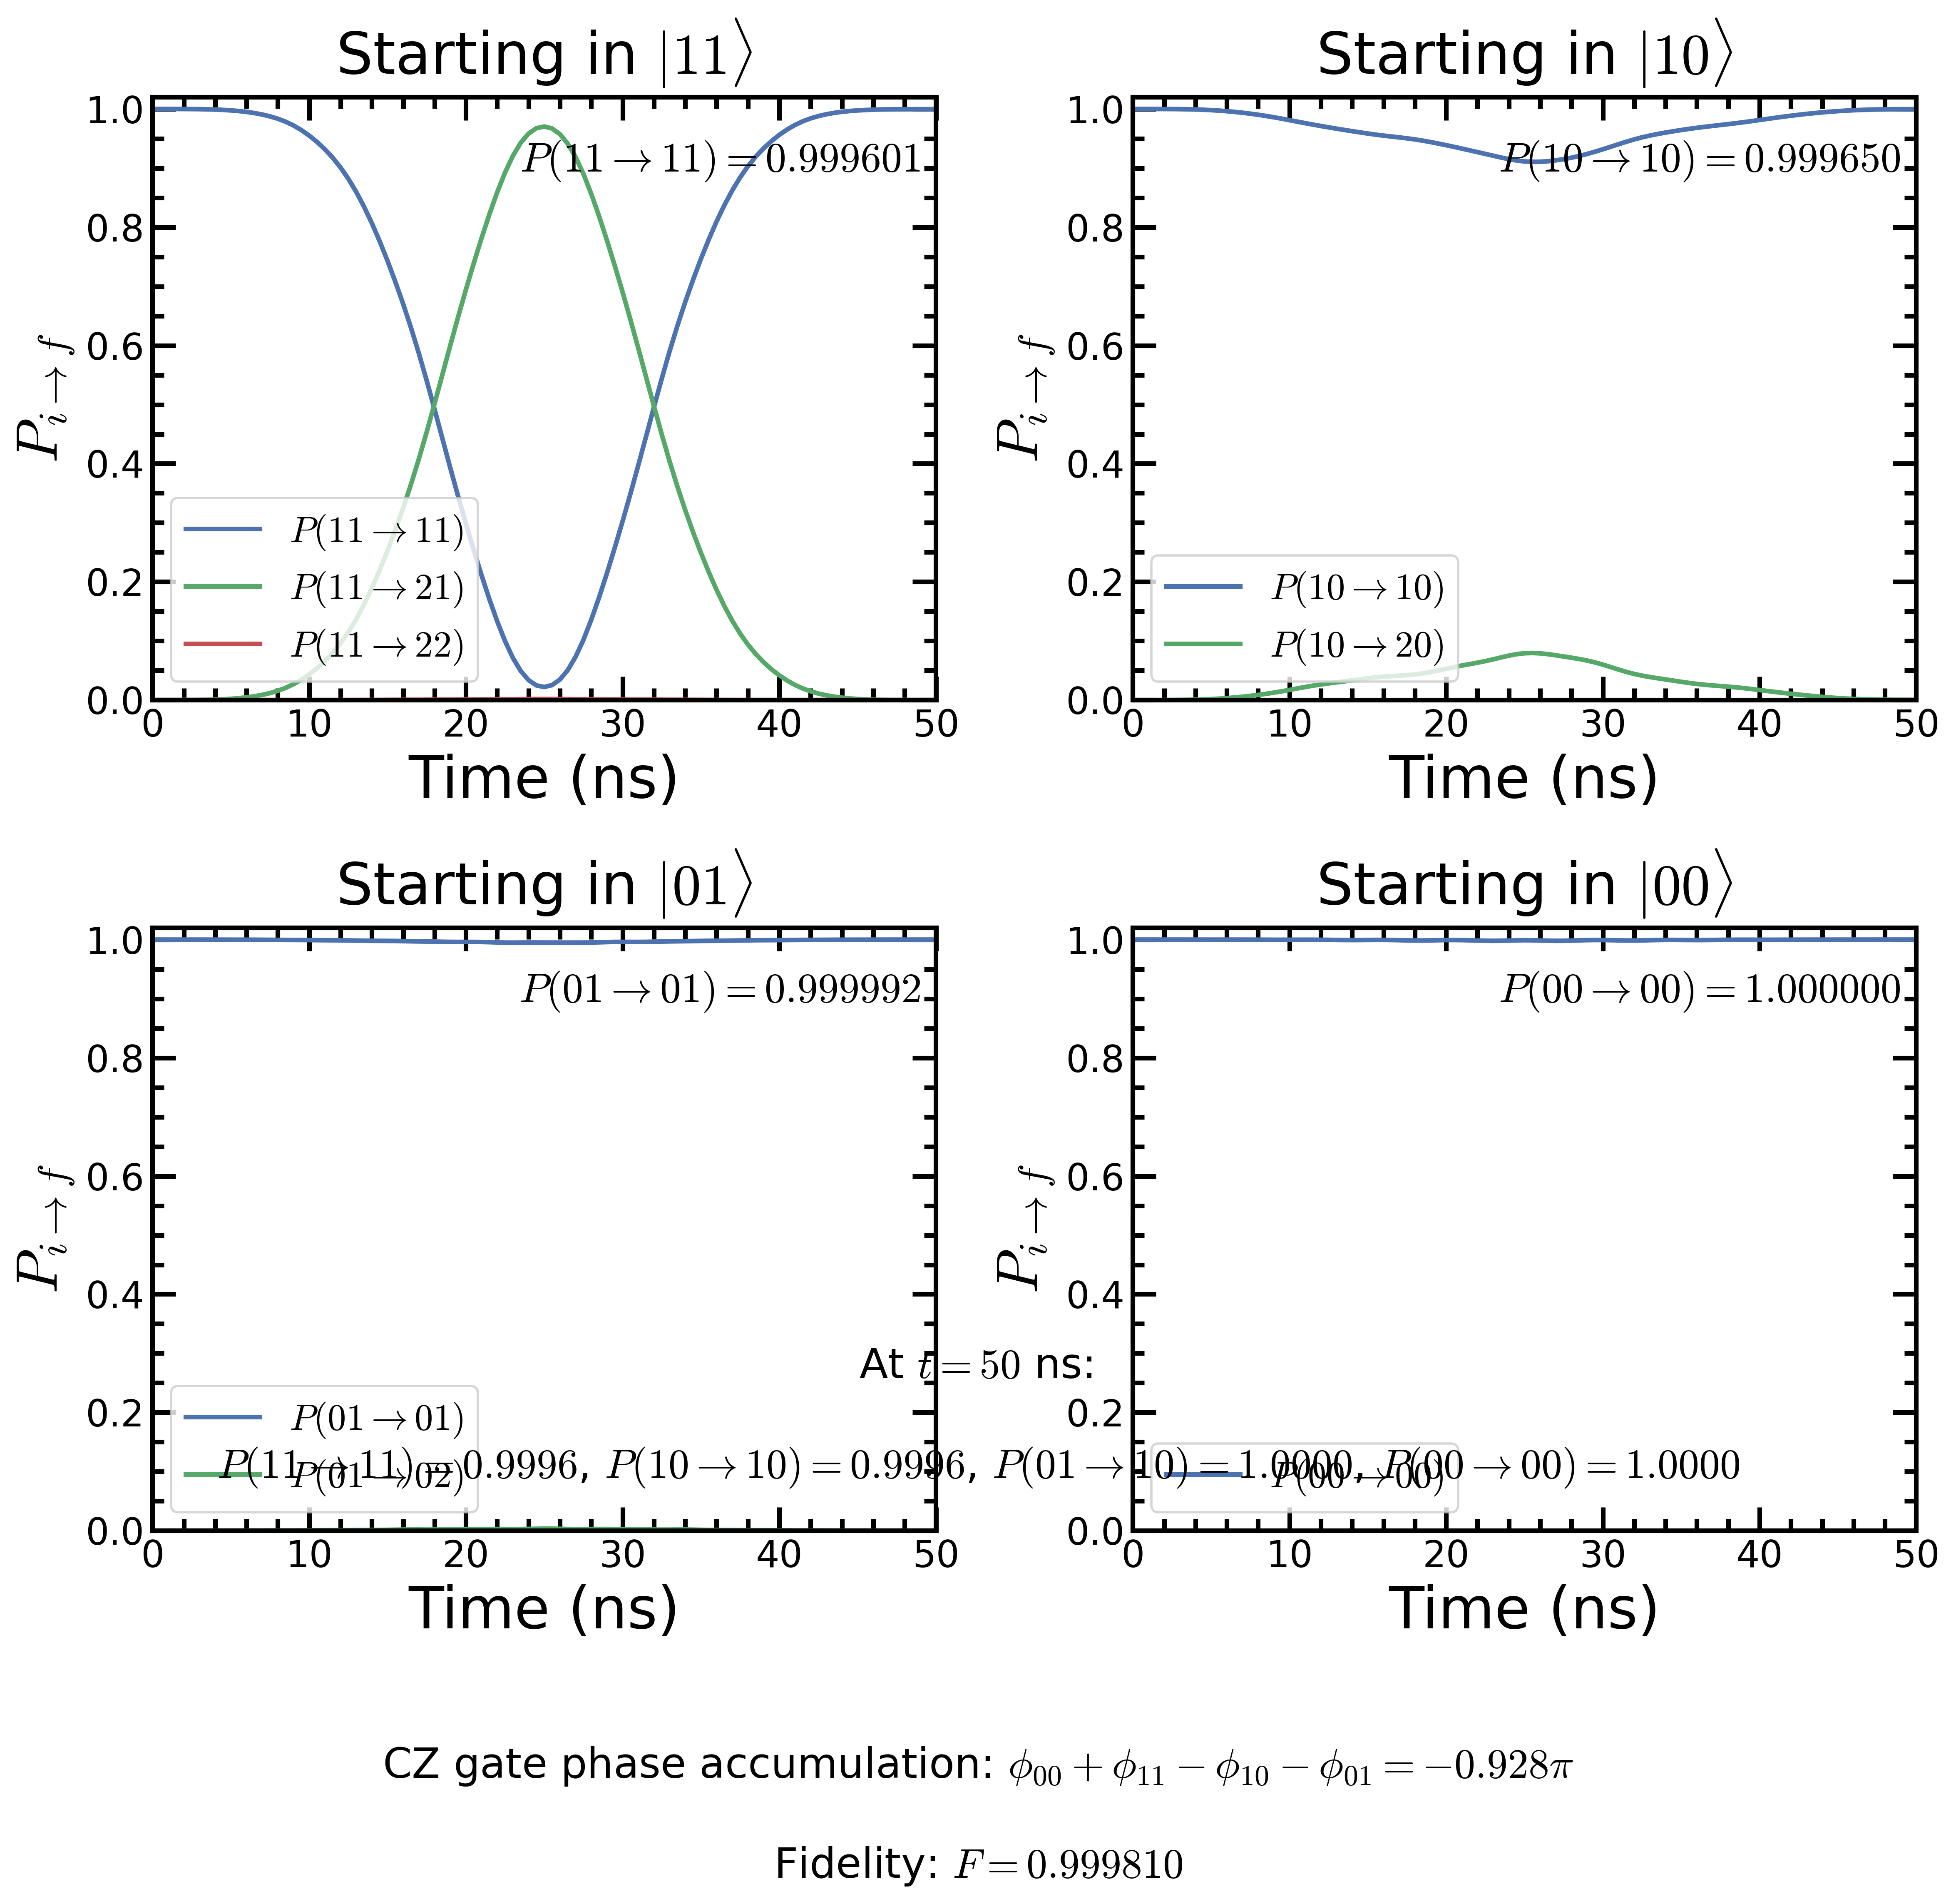

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

ax011 = axes[0, 0]
ax010 = axes[0, 1]
ax001 = axes[1, 0]
ax000 = axes[1, 1]

for state in states011:
    P011[state] = gates.prob_transition(U_t, system.eigvec('11'), system.eigvec(state))
    ax011.plot(t_points, P011[state], lw=2,
               label=r'$P(11\rightarrow{})$'.format(state))

for state in states010:
    P010[state] = gates.prob_transition(U_t, system.eigvec('10'), system.eigvec(state))
    ax010.plot(t_points, P010[state], lw=2,
               label=r'$P(10\rightarrow {})$'.format(state))

for state in states001:
    P001[state] = gates.prob_transition(U_t, system.eigvec('01'), system.eigvec(state))
    ax001.plot(t_points, P001[state], lw=2,
               label=r'$P(01\rightarrow {})$'.format(state))

for state in states000:
    P000[state] = gates.prob_transition(U_t, system.eigvec('00'), system.eigvec(state))
    ax000.plot(t_points, P000[state], lw=2,
               label=r'$P(00\rightarrow {})$'.format(state))

textfontsize = 18
fig.text(0.5, 0.3, r'At $t = {}$ ns: '.format(int(t_points[-1])),
        fontsize=textfontsize, ha='center')
fig.text(0.5, 0.25,
        r'$P(11\rightarrow 11) = {:.4f}$, '.format(P011['11'][-1])
        + r'$P(10\rightarrow 10) = {:.4f}$, '.format(P010['10'][-1])
        + r'$P(01\rightarrow 10) = {:.4f}$, '.format(P001['01'][-1])
        + r'$P(00\rightarrow 00) = {:.4f}$'.format(P000['00'][-1]),
        fontsize=textfontsize, ha='center')
ax011.text(0.98, 0.93,
           r'$P(11 \rightarrow 11) = {:.6f}$'.format(P011['11'][-1]),
           ha='right', va='top', transform=ax011.transAxes,
           fontsize=textfontsize)
ax010.text(0.98, 0.93,
           r'$P(10 \rightarrow 10) = {:.6f}$'.format(P010['10'][-1]),
           ha='right', va='top', transform=ax010.transAxes,
           fontsize=textfontsize)
ax001.text(0.98, 0.93,
           r'$P(01 \rightarrow 01) = {:.6f}$'.format(P001['01'][-1]),
           ha='right', va='top', transform=ax001.transAxes,
           fontsize=textfontsize)
ax000.text(0.98, 0.93,
           r'$P(00 \rightarrow 00) = {:.6f}$'.format(P000['00'][-1]),
           ha='right', va='top', transform=ax000.transAxes,
           fontsize=textfontsize)
# fig.text(0.65, 0.25, r'$P(10) = {:.4f}$'.format(
#          P010['10'][-1]), fontsize=textfontsize)
fig.text(0.5, 0.1,
         r'CZ gate phase accumulation: '
         + '$\phi_{00} + \phi_{11} - \phi_{10} - \phi_{01} = $'
         + r'${:.3f} \pi $'.format(phase_accum),
         fontsize=textfontsize, ha='center')
fig.text(0.5, 0.05,
         r'Fidelity: '
         + r'$F = {:.6f}$'.format(1-infidelity(xopt.x)),
         fontsize=textfontsize, ha='center')

for axarr in axes:
    for ax in axarr:
        ax.legend(loc='lower left')
        ax.set_xlim([np.min(t_points), np.max(t_points)])
        ax.set_xlabel('Time (ns)')
        ax.set_ylim([0, 1.02])
        ax.set_ylabel(r'$P_{i\rightarrow f}$')

ax011.set_title(
    r'Starting in $|11\rangle$')
ax010.set_title(
    r'Starting in $|10\rangle$')

ax001.set_title(
    r'Starting in $|01\rangle$')
ax000.set_title(
    r'Starting in $|00\rangle$')

fig.tight_layout(rect=[0, 0.15, 1, 1])

P_driven_transition = gates.prob_transition(U_t, initial_state, final_state)

t_2nd_excited = scipy.integrate.trapz(P_driven_transition, t_points)
print('Time spent in the 2nd state for {} - {}: {:.1f} ns'.format(
    transition_to_drive[0], transition_to_drive[1],
    t_2nd_excited))

## Sweep gate time

In [ ]:
#Gate parameter
T_gate_array = np.linspace(20,100,41) #ns
error_array = np.zeros_like(T_gate_array)
drag_coeff_array = np.zeros_like(T_gate_array)
delta_omega_d_array = np.zeros_like(T_gate_array)

for T_idx, T_gate in enumerate(T_gate_array):
  
    t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
    delta_omega_d = 0
    drag_coeff = 0

    x0 = [delta_omega_d, drag_coeff]
    xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-6)
    
    error_array[T_idx] = infidelity(xopt.x)
    delta_omega_d[T_idx] = xopt.x[0]
    drag_coeff[T_idx] = xopt.x[1]

# Pauli Transfer Matrix

<ipython-input-41-b81d3593c91c>:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ptm_real =  Qobj(np.linalg.lstsq(p_out, p_in)[0])


(<Figure size 3200x2400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc0be4f9af0>)

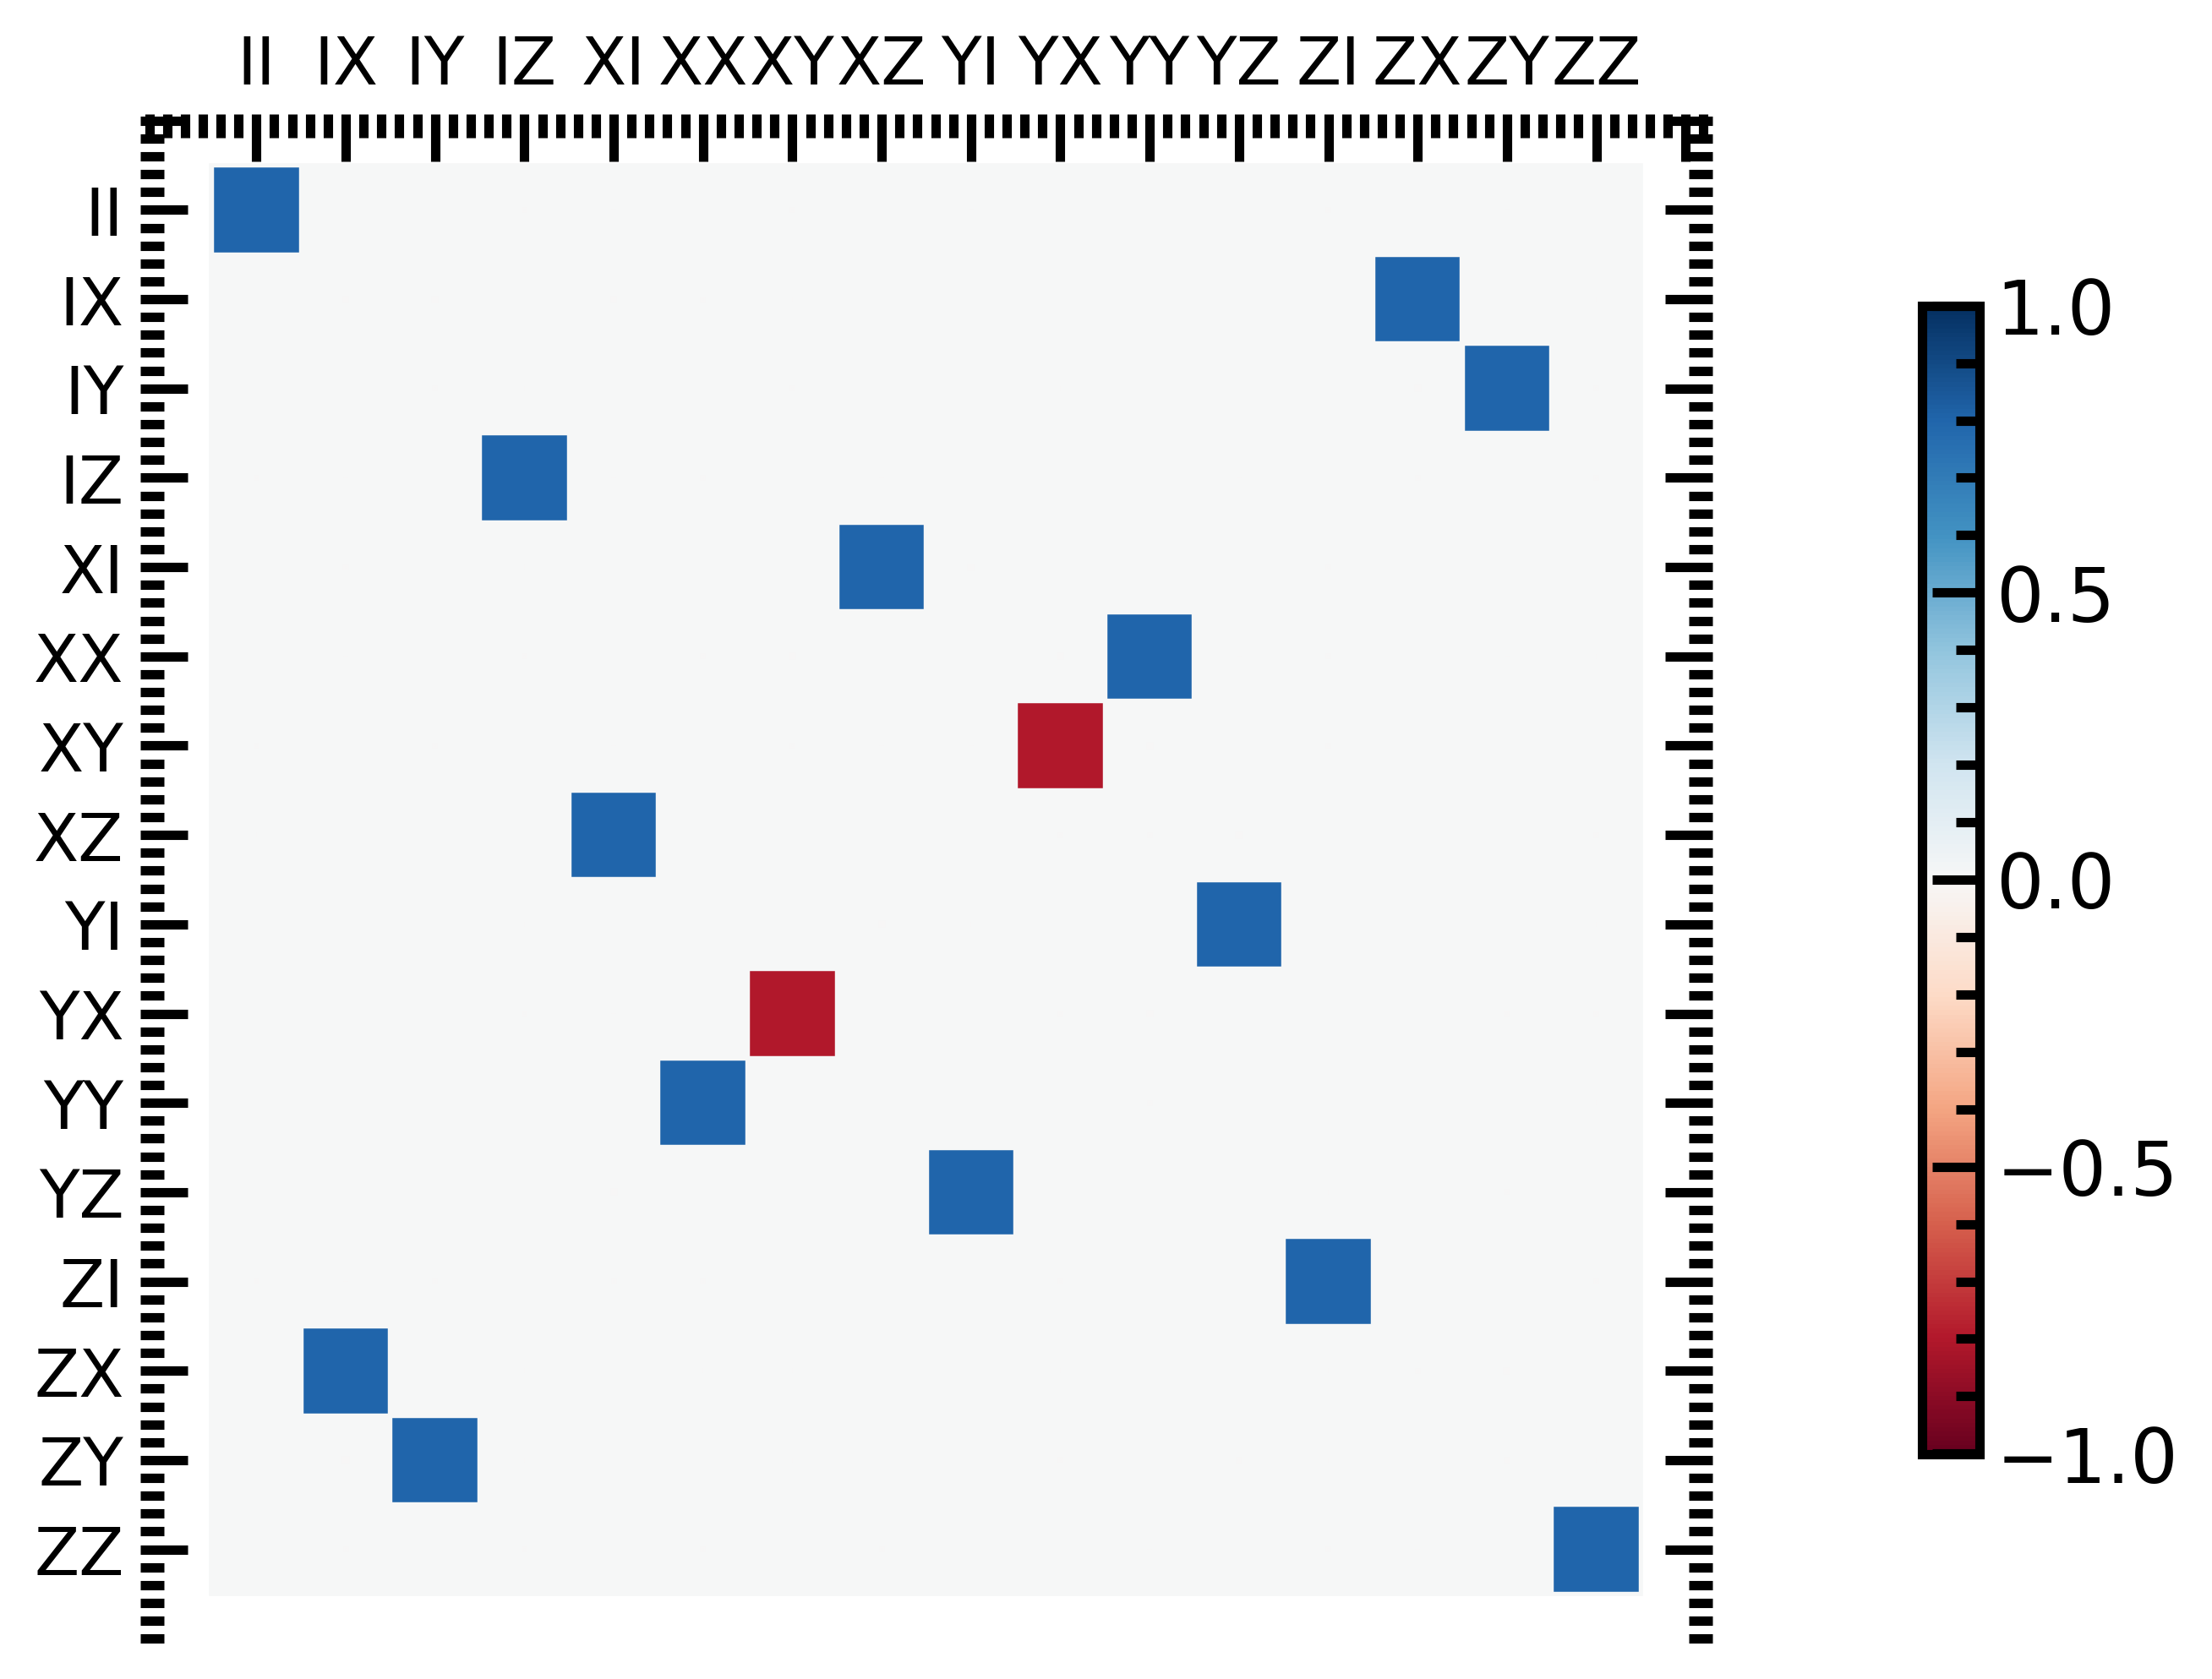

In [41]:
prep_ops = [qeye(nlev_q ), op.sx(phi=np.pi/2, N=nlev_q ), op.sy(phi=-np.pi/2, N=nlev_q ), op.sigx(N=nlev_q )]
meas_ops = [qeye(nlev_q ), op.sigx(N=nlev_q ), op.sigy(N=nlev_q ), op.sigz(N=nlev_q )]
prep_rotations = []
for q1gate in prep_ops:
    for q2gate in prep_ops:
        gate = (tensor(q1gate, q2gate))
        prep_rotations.append(gate)
meas_rotations = []
for q1gate in meas_ops:
    for q2gate in meas_ops:
        gate = (tensor(q1gate, q2gate))
        meas_rotations.append(gate)
p_in = np.zeros((16,16), dtype = complex)
p_out = np.zeros((16,16), dtype = complex)
# state_0 = tensor(basis(nlev_q,0), basis(nlev_q,0)) 
state_0 = system.eigvec('00')
for i, prep in enumerate(prep_rotations):
    psi_ini = prep*state_0
    evol_states = gates.evolution_psi_microwave(system.H(), H_drive, psi0 = psi_ini, comp_space=comp_space, 
                                                t_points=t_points,T_gate=T_gate, shape=shape, 
                                                sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, 
                                                omega_d=omega_d,interaction=interaction)
    
    for j, meas in enumerate(meas_rotations):
        p_in[i,j] = np.real(expect(meas, psi_ini))
        p_out[i,j] = np.real(expect(meas, single_qubit_gates*evol_states[-1]))
        
ptm_real =  Qobj(np.linalg.lstsq(p_out, p_in, rcond=None)[0])

str_primitive = ["I","X","Y","Z"]
op_label = []
for prim1 in str_primitive:
    for prim2 in str_primitive:
        op_label.append(prim1+prim2)
hinton(ptm_real, xlabels = op_label, ylabels = op_label)  

## Estimating error channel

In [50]:
#List of collapse operators
gamma1_01 = (50e6)**-1.0
gamma2_01 = (5e3)**-1.0
L1_01 = np.sqrt(gamma1_01)*(system.eigvec('00')*system.eigvec('01').dag() + system.eigvec('00')*system.eigvec('10').dag())
L2_01 = np.sqrt(2*gamma2_01)*(system.eigvec('01')*system.eigvec('01').dag() + system.eigvec('10')*system.eigvec('10').dag()+system.eigvec('11')*system.eigvec('11').dag())

gamma1_02 = (53e3)**-1
gamma2_02 = (52e3)**-1
L1_02 = np.sqrt(gamma1_02)*(system.eigvec('00')*system.eigvec('02').dag() + system.eigvec('00')*system.eigvec('20').dag())
L2_02 = np.sqrt(2*gamma2_02)*(system.eigvec('02')*system.eigvec('02').dag() + system.eigvec('20')*system.eigvec('20').dag()+system.eigvec('22')*system.eigvec('22').dag())

gamma1_12 = (786e3)**-1
gamma2_12 = (6e3)**-1
L1_12 = np.sqrt(gamma1_12)*(system.eigvec('10')*system.eigvec('20').dag() + system.eigvec('11')*system.eigvec('21').dag()
                           + system.eigvec('01')*system.eigvec('02').dag() + system.eigvec('11')*system.eigvec('12').dag())
L2_12 = np.sqrt(2*gamma2_12)*(system.eigvec('02')*system.eigvec('02').dag() + system.eigvec('20')*system.eigvec('20').dag()
                              +system.eigvec('12')*system.eigvec('12').dag() + system.eigvec('21')*system.eigvec('21').dag()
                              +system.eigvec('22')*system.eigvec('22').dag())


c_ops = [L1_01,L2_01, L1_02,L2_02, L1_12,L2_12]

In [51]:
prep_ops = [qeye(nlev_q ), op.sx(phi=np.pi/2, N=nlev_q ), op.sy(phi=-np.pi/2, N=nlev_q ), op.sigx(N=nlev_q )]
meas_ops = [qeye(nlev_q ), op.sigx(N=nlev_q ), op.sigy(N=nlev_q ), op.sigz(N=nlev_q )]
prep_rotations = []
for q1gate in prep_ops:
    for q2gate in prep_ops:
        gate = (tensor(q1gate, q2gate))
        prep_rotations.append(gate)
meas_rotations = []
for q1gate in meas_ops:
    for q2gate in meas_ops:
        gate = (tensor(q1gate, q2gate))
        meas_rotations.append(gate)
p_in_diss = np.zeros((16,16), dtype = complex)
p_out_diss = np.zeros((16,16), dtype = complex)
# state_0 = tensor(basis(nlev_q,0), basis(nlev_q,0))
state_0 = system.eigvec('00')
for i, prep in enumerate(prep_rotations):
    psi_ini = prep*state_0
    evol_states = gates.evolution_psi_microwave_diss(system.H(), H_drive, psi0 = psi_ini, comp_space=comp_space, 
                                                t_points=t_points,T_gate=T_gate, shape=shape, 
                                                sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, 
                                                omega_d=omega_d,interaction=interaction, c_ops = c_ops)
    
    for j, meas in enumerate(meas_rotations):
        p_in_diss[i,j] = np.real(expect(meas, psi_ini))
        p_out_diss[i,j] = np.real(expect(meas, single_qubit_gates*evol_states[-1]*single_qubit_gates.dag()))
         

(<Figure size 3200x2400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc089a312e0>)

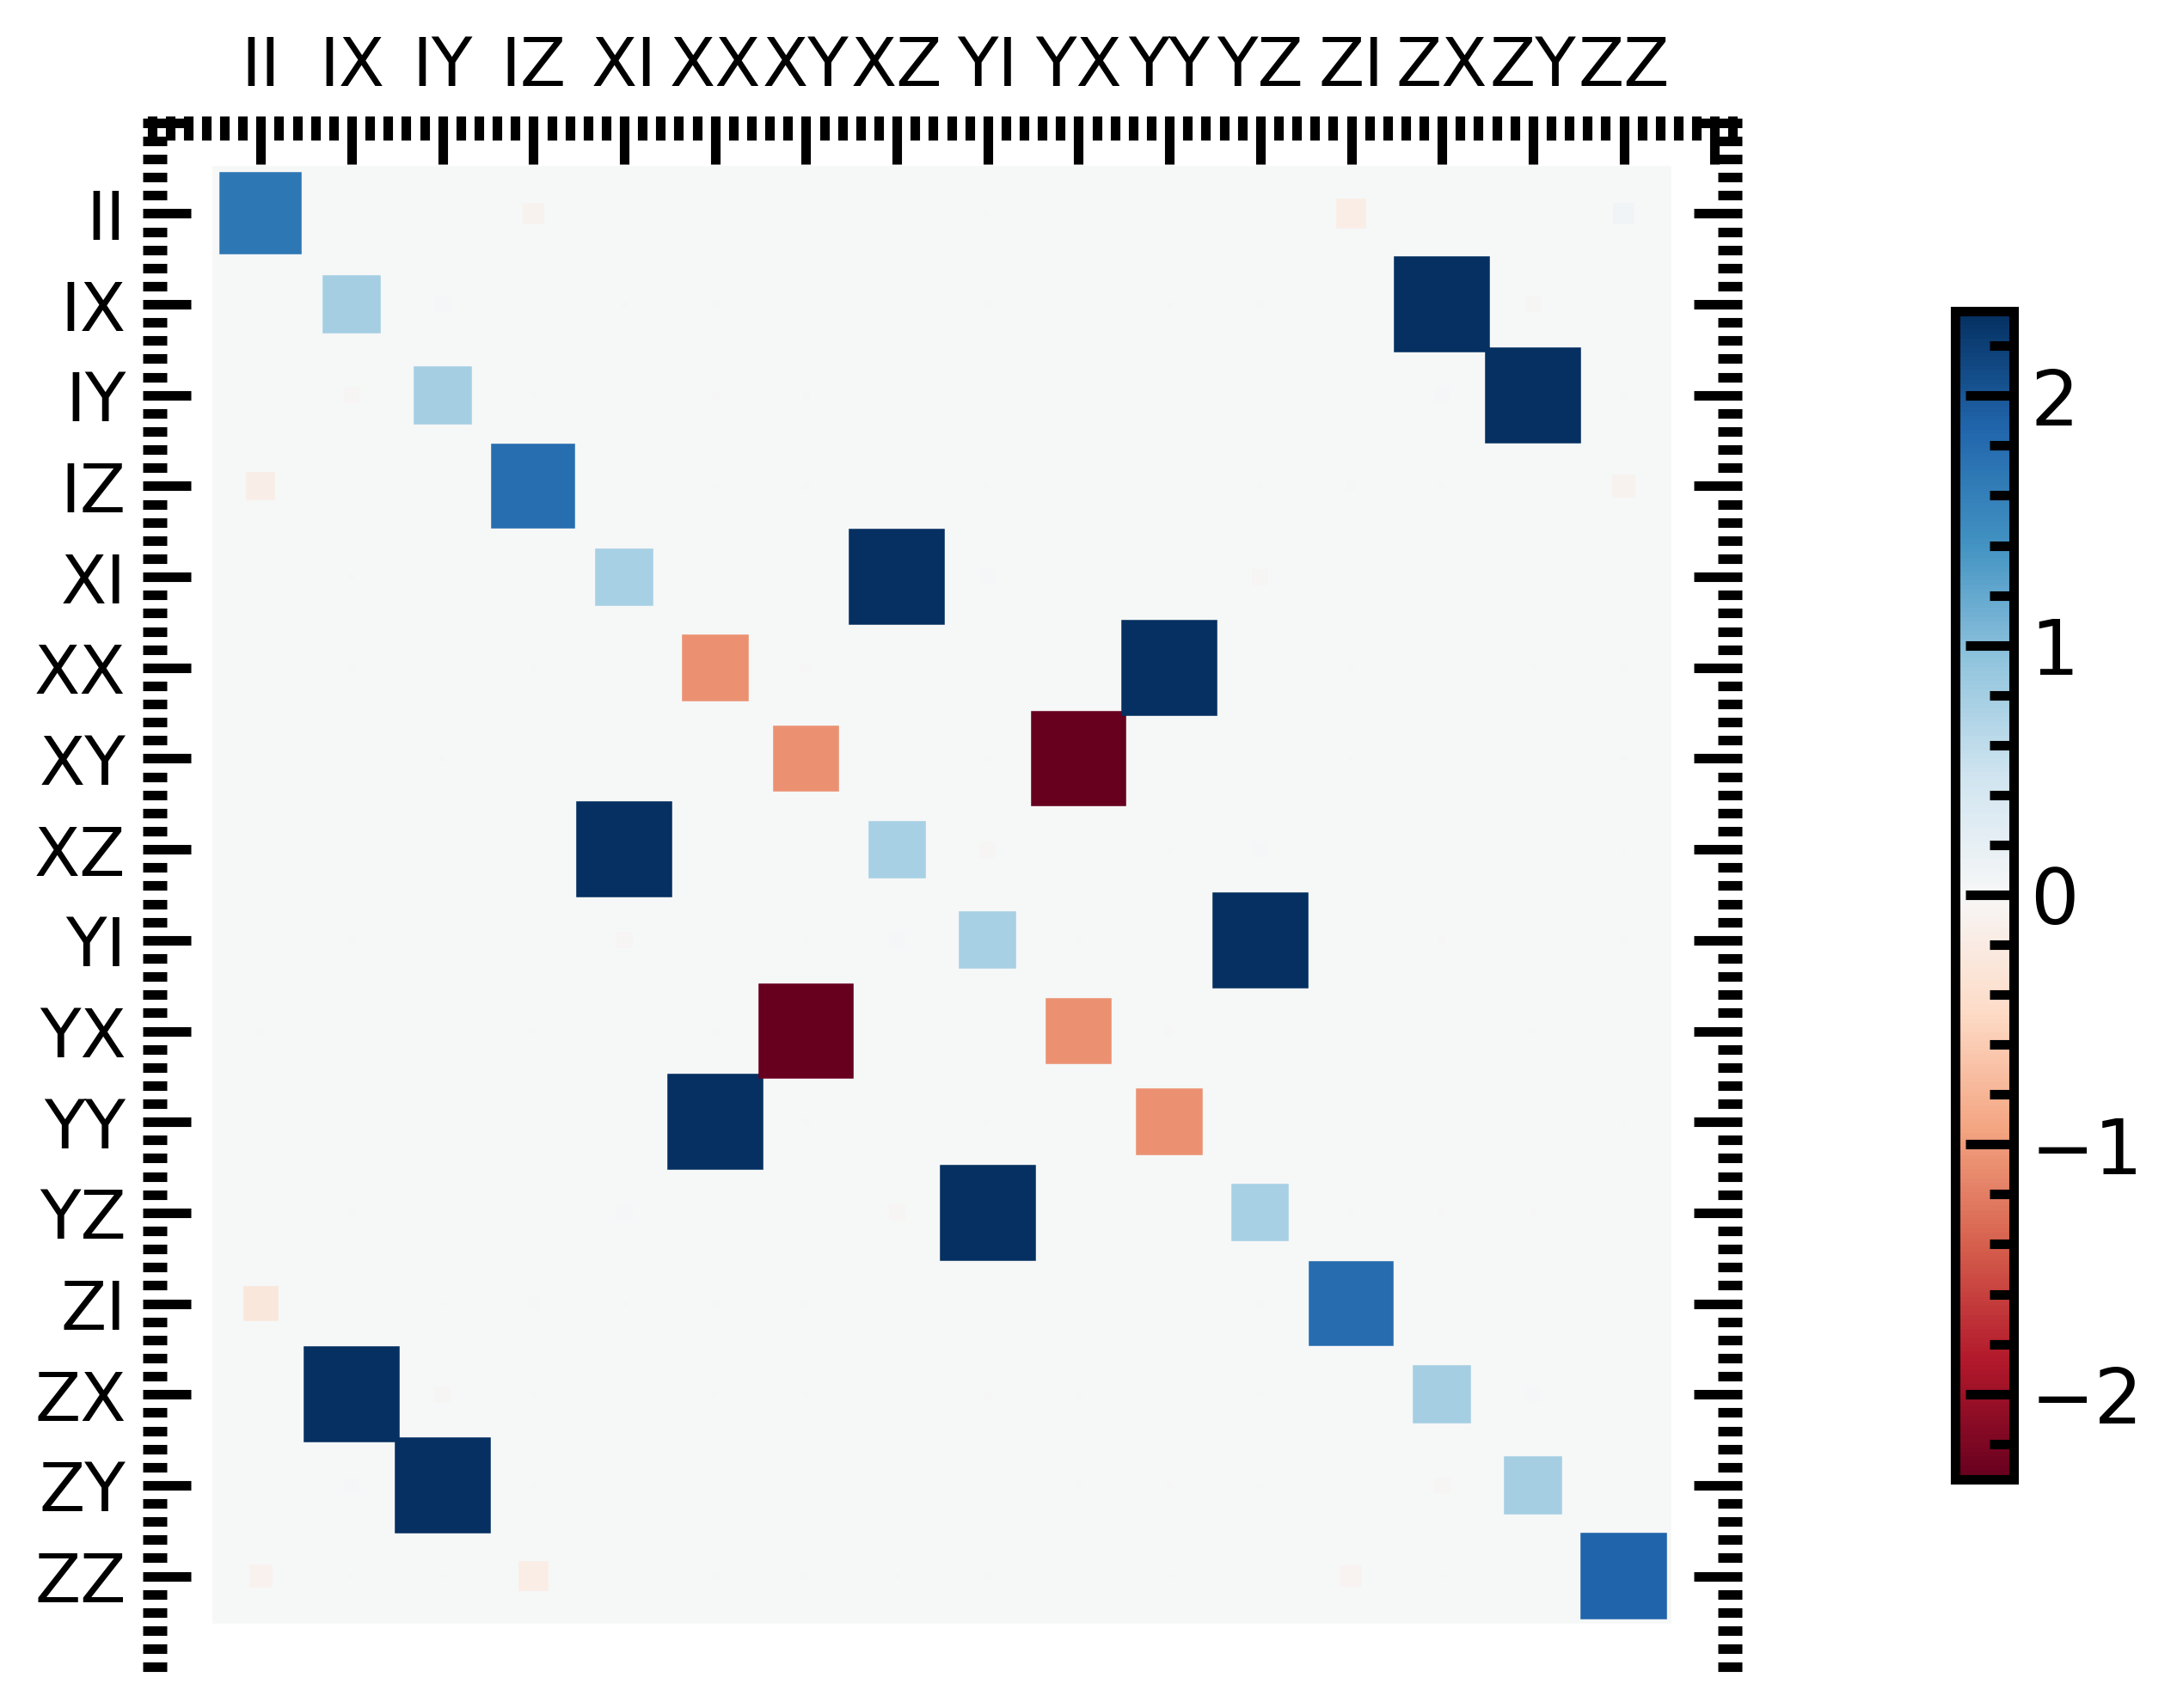

In [53]:
ptm_real_diss =  Qobj(np.linalg.lstsq(p_out_diss, p_in_diss, rcond=None)[0])

str_primitive = ["I","X","Y","Z"]
op_label = []
for prim1 in str_primitive:
    for prim2 in str_primitive:
        op_label.append(prim1+prim2)
hinton(ptm_real_diss, xlabels = op_label, ylabels = op_label) 

### Checking

<ipython-input-48-e00f614816a0>:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  prep_generator = [qeye(2), ry(np.pi/2.0), rx(np.pi/2.0), sigmax()]
<ipython-input-48-e00f614816a0>:22: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  gate_op = cphase(np.pi)


(<Figure size 3200x2400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc08ed3b880>)

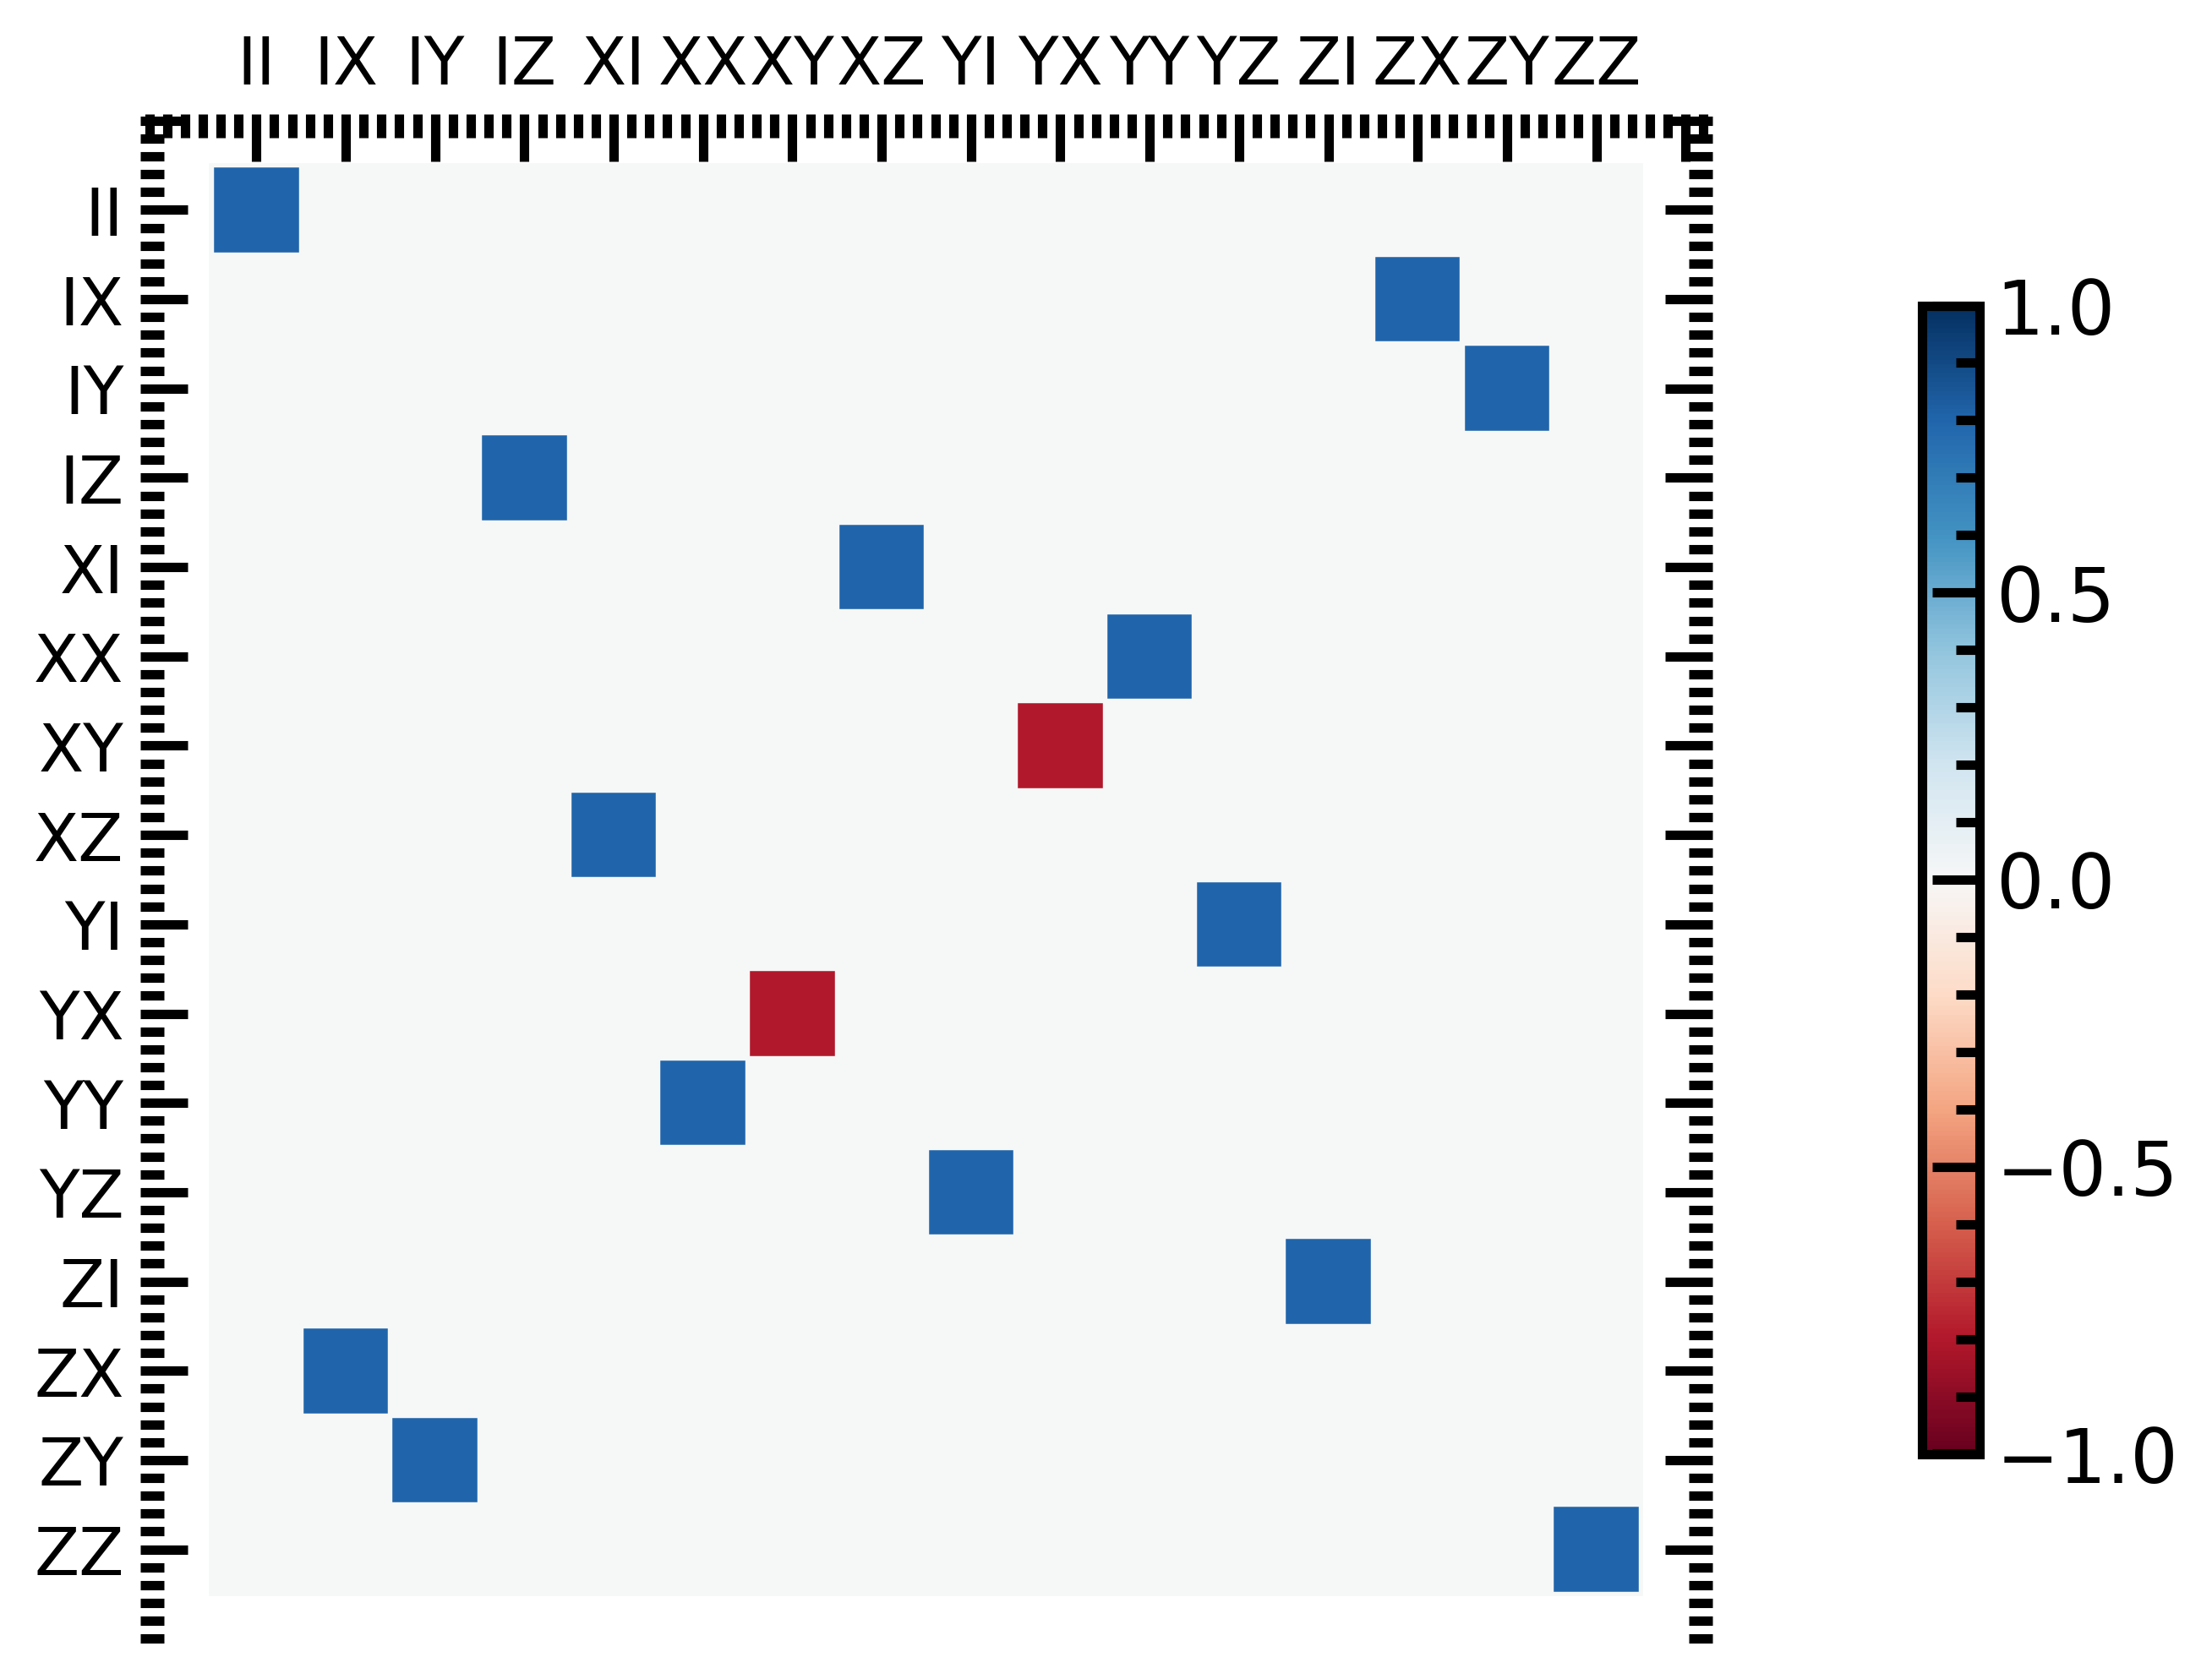

In [48]:
prep_generator = [qeye(2), ry(np.pi/2.0), rx(np.pi/2.0), sigmax()]
prep_rotations = []
for q1gate in prep_generator:
    for q2gate in prep_generator:
        gate = (tensor(q1gate, q2gate))
        prep_rotations.append(gate)

meas_generator = [qeye(2), sigmax(), sigmay(), sigmaz()]
meas_rotations = []
for q1gate in meas_generator:
    for q2gate in meas_generator:
        gate = (tensor(q1gate, q2gate))
        meas_rotations.append(gate)
        
p_in = np.zeros((16,16)) 
p_out = np.zeros((16,16)) 

gnd_state = tensor(basis(2,0), basis(2,0))
# gate_op = tensor(qeye(2), rx(np.pi/2))
# gate_op = tensor(rx(np.pi/2), qeye(2))
# gate_op = cnot()
gate_op = cphase(np.pi)
for i, rot_i in enumerate(prep_rotations):
    for j, rot_j in enumerate(meas_rotations):
        p_in[i,j] = expect(rot_j, rot_i*gnd_state)
        p_out[i,j] = expect(rot_j, gate_op*(rot_i*gnd_state))        
ptm_ideal = np.linalg.lstsq(p_in, p_out, rcond = None)[0]
hinton(ptm_ideal, xlabels = op_label, ylabels = op_label) 

(<Figure size 3200x2400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc07ab44550>)

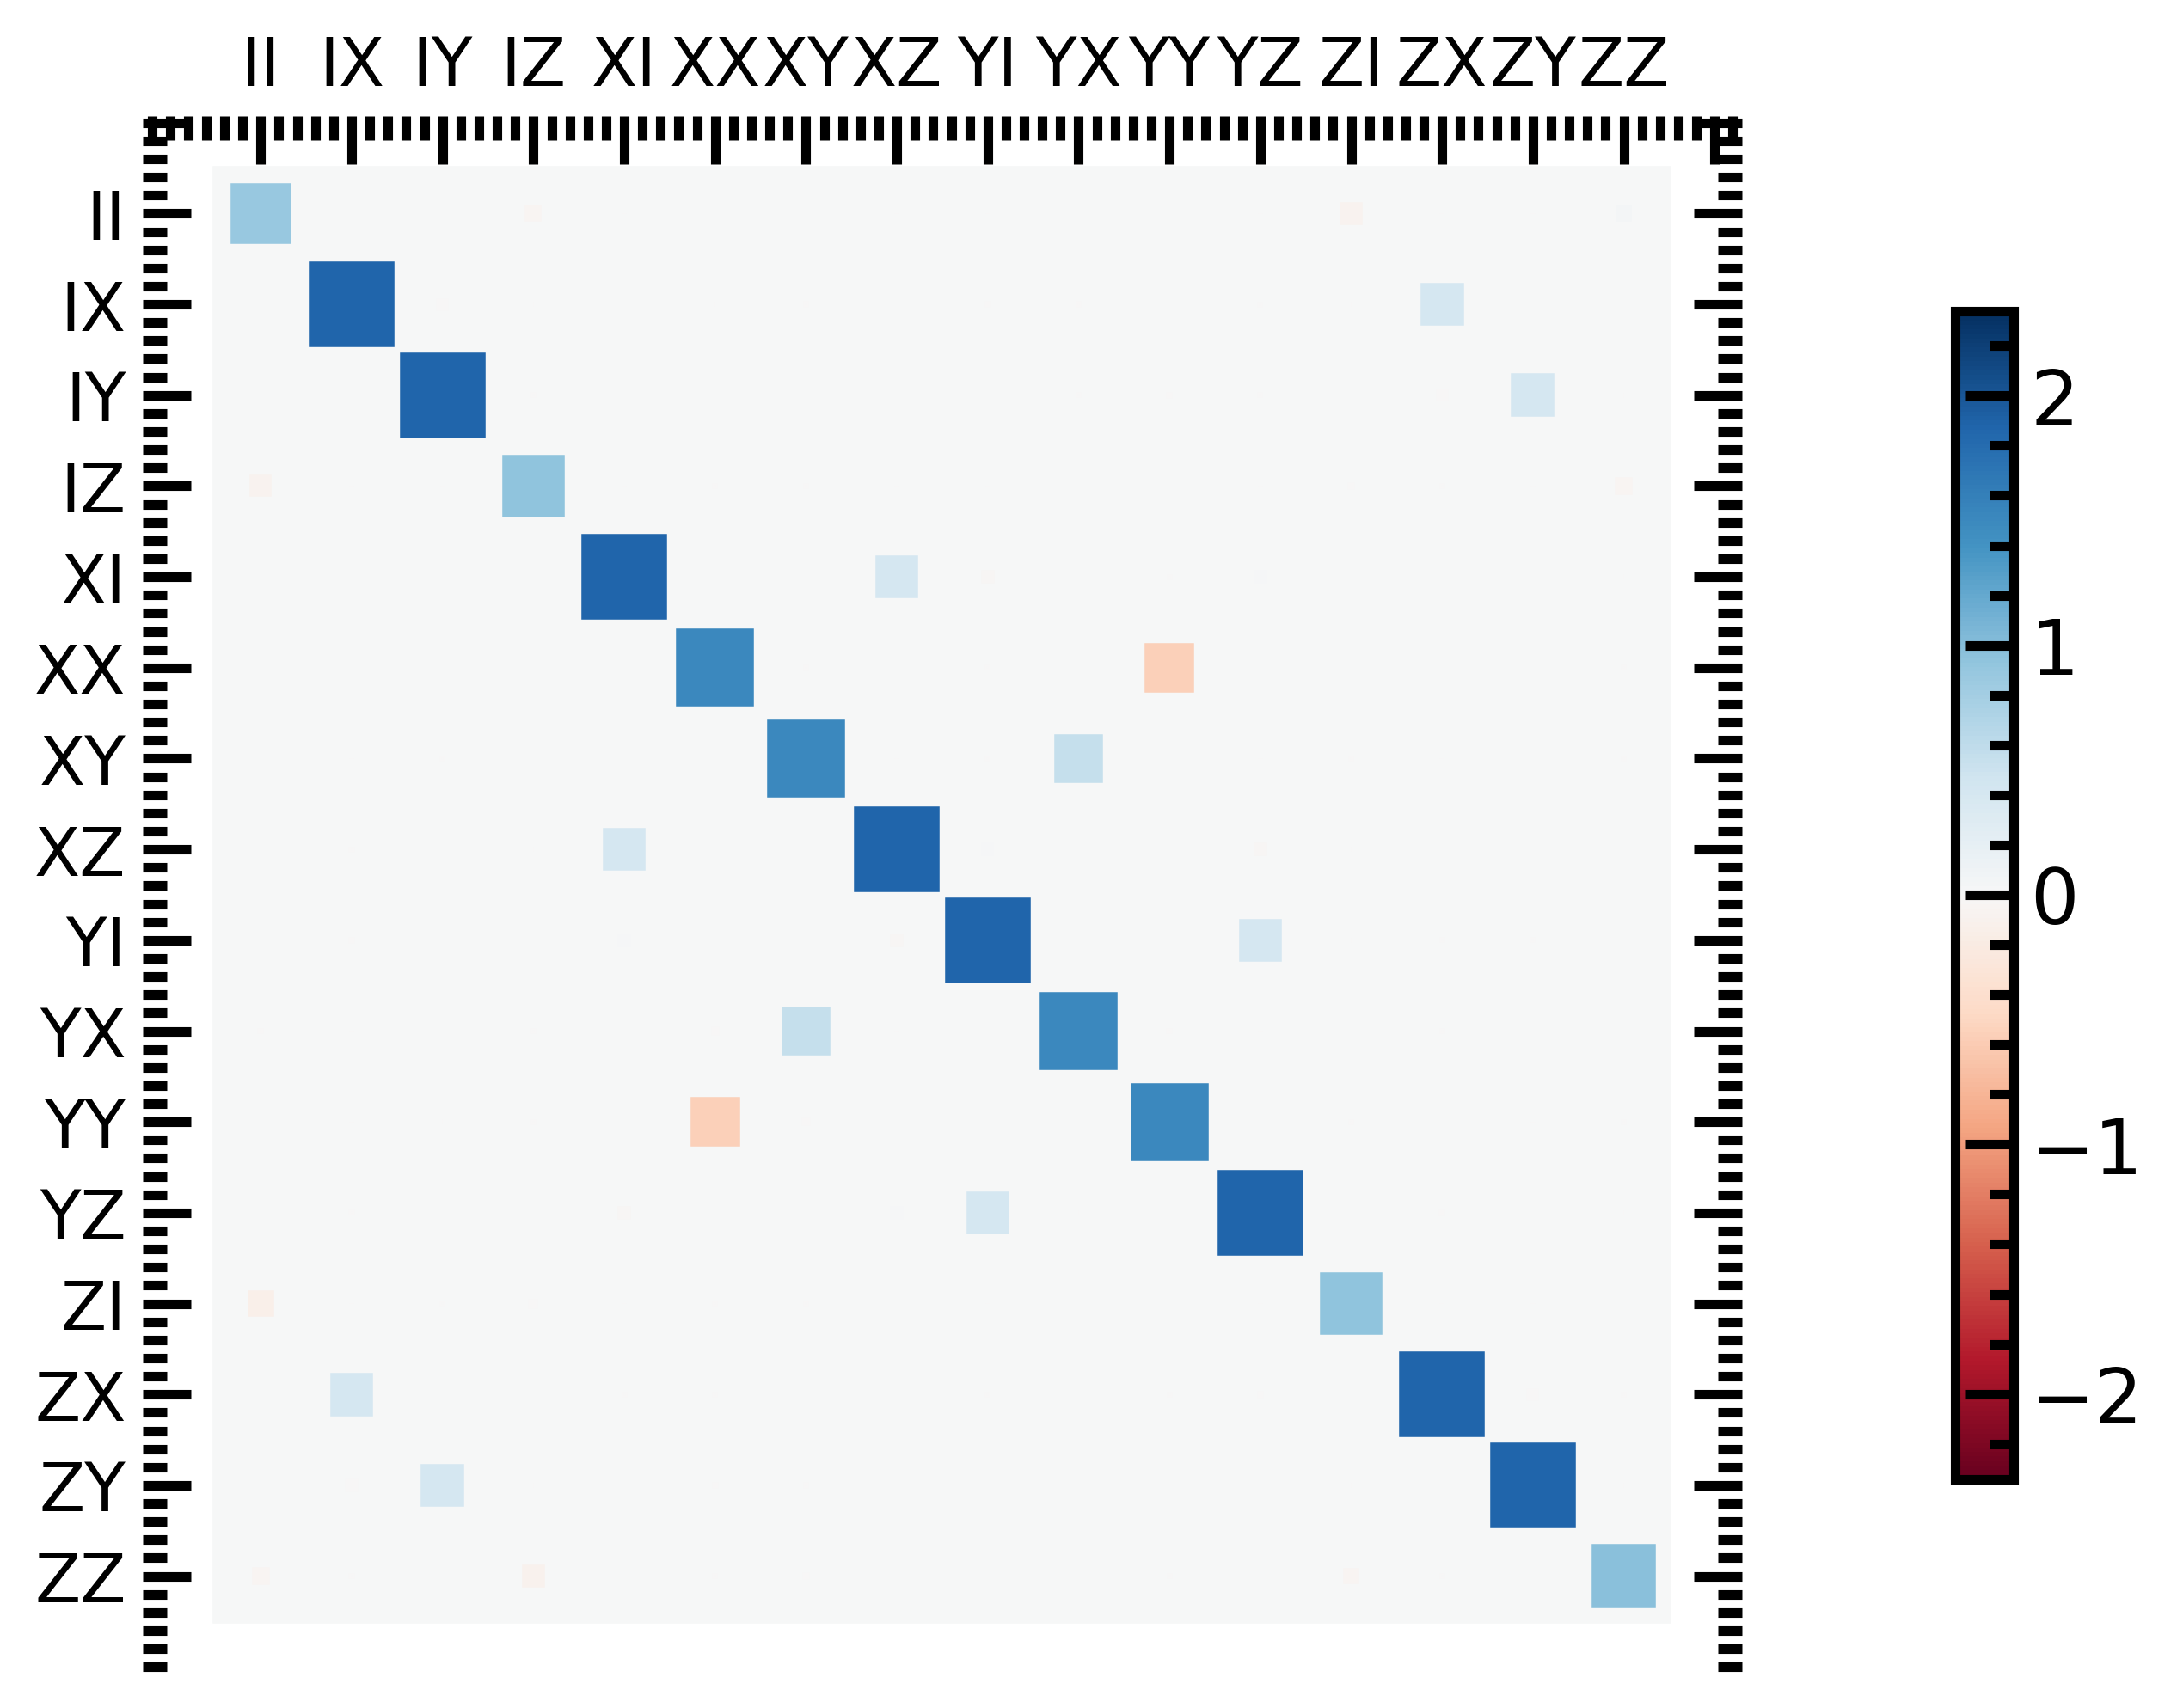

In [54]:
ptm_error = ptm_real_diss*Qobj(np.linalg.inv(ptm_ideal))
hinton(ptm_error, xlabels = op_label, ylabels = op_label) 

In [36]:
d = 4
process_fidelity = abs(np.trace(ptm_real.dag()*ptm_ideal) + d)/(d**2+d)
print (process_fidelity)

1.0000910276529298


In [31]:
for state in comp_space:
    vec = system.eigvec(state, interaction=interaction)
    phase = np.angle(U_f.matrix_element(vec.dag(), vec))
    print (U_f.matrix_element(vec.dag(), vec))

(-0.9956915969345734+0.09272702476602902j)
(0.78675365011157+0.6172647898925925j)
(0.8959776818030607+0.4436326993280744j)
(0.16066010608836542+0.986732015596071j)
